## An augmentation based deep neural network approach to learn human driving behavior

### Vivek Yadav, PhD

This jupyter notebook presents my submission for project 3: Behavior cloning for fulfilment of Udacity's self-driving car nanodegree. I have also made a [medium post](https://medium.com/@vivek.yadav/using-augmentation-to-mimic-human-driving-496b569760a9#.z4u3clepp) with more detailed simulation results. This code presents the code for the project. 


### Overview

Objective of this project is to develop a deep learning based algorithm to mimic driving behavior of human. Data was collected (by me) while driving around the track 1 in simulator. I used a ps4 controller to drive around the track. I then used image augmentation to generate multiple training samples that represented driving under different driving conditions. I did not use validation data, because validaiton data's performance did not transfer to the driving on track. I did include validation as a sanity check to verify if neural network training was working well. I had models that showed very low validation score, but poor transfer, and others that had higher validation scores and showed better performance. So I decided to instead check driving performance on track 1 as validation. I discarded models that did not complete 1 full lap. My validation test was driving performance on track 1 in naive conditions, and I tested it by running the model on different track and resolutions/image sizes of track 1. 

Below are code for importing data, augmenting images and training the model. But before getting into the methods, below are results showing model's performance in two test cases. 


### Results: 

Once I got the steering angles, I increased the value of the steering angle by 20% (multiplied by 1.2) to make the car more responsive. The main reason to do so was while training I went over the edges a few times, and corrected. I wanted the car to avoid those mistakes, so used higher gain on steering angle. 



#### 1. Behavior cloning of human driving. 

Model for track 1 can be ran using the command, 

```
python drive.py model.json
```


Video below presents performance of the algorithm on the first track. No simulator parameters were changed in this case. The neural network based controller was able to drive the car around the track on its own. 

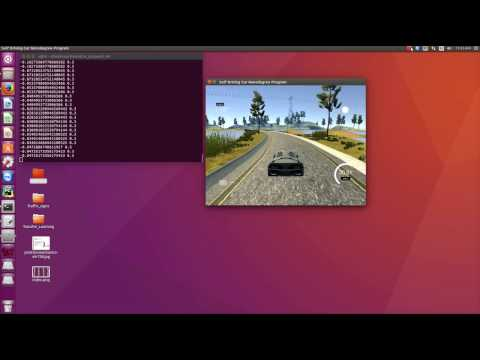

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("k5GWzzE1qaU")

#### 2. Transfer from one track to another. 

Model for track 1 can be ran using the command, 

```
python drive_track2.py model.json
```

To run the car on the second track,

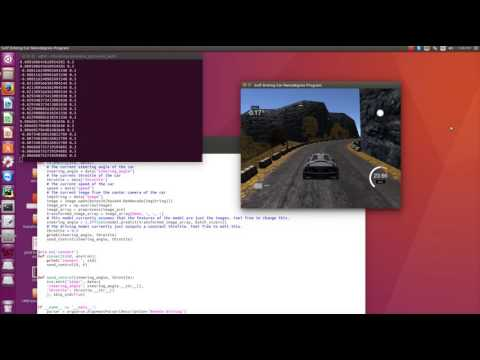

In [2]:
YouTubeVideo("W5bwYNwpt1I")

## Python code for generating the trainer

### Importing packages

In [3]:
### Importing packages. 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cv2
import math


### Functions to calculate moving average and compute butterworth filter.


I wrote these functions to calculate smoother steering data. I used moving average filter to smooth steering angle. 

In [4]:
def butter_lowpass(x,fcut,f_sample,order,plen): 
    # x: unfilteted data
    # fcut : cutoff frequency
    # f_sample : sampling frequency
    # order : Order of filter (usually 4)
    # plen: padding length (typically left as 0)
    
    rat = fcut/f_sample

    b, a = signal.butter(order, rat)
    y = signal.filtfilt(b, a, x, padlen=plen)
    return y

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

### Loading data

In [5]:
csv_path = 'straight_lap/driving_log.csv'
data_files_s = pd.read_csv(csv_path, header =None,
                         names=['center','left','right','steer','throttle','break'],
                        index_col = False)
data_files_s['direction'] = pd.Series('s', index=data_files_s.index)

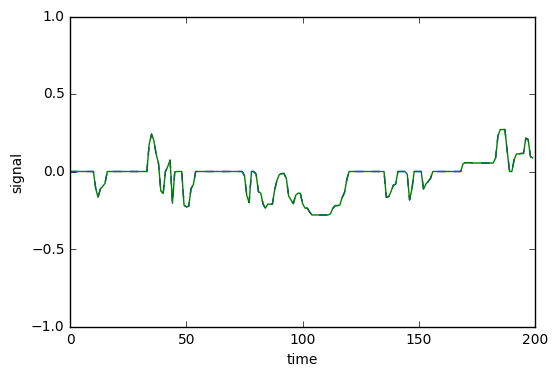

In [6]:
len_plt = 200

rev_steer_s = np.array(data_files_s.steer,dtype=np.float32)


t_s = np.arange(len(rev_steer_s))
x_s = np.array(data_files_s.steer)
y_s = rev_steer_s

steer_sm_s = rev_steer_s


plt.plot(t_s[0:len_plt],x_s[0:len_plt],'--',t_s[0:len_plt],y_s[0:len_plt]);
plt.xlabel('time')
plt.ylabel('signal')
plt.ylim(-1,1);

data_files_s['steer_sm'] = pd.Series(steer_sm_s, index=data_files_s.index)



#### Removing data with speed below .25

In [7]:
ind = data_files_s['throttle']>.25
data_files_s= data_files_s[ind].reset_index()

In [8]:
len(data_files_s)

8272

In [9]:
def process_newimage_file(name):
    image = cv2.imread(name)
    #image = cv2.resize(image,(120,120))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.-.5
    return image

### Augmentation 1: Including LR images. 

Figure below presents images from left, center and right images. 

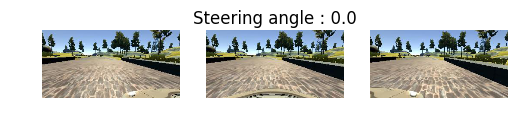

In [10]:
ind_num = 29

image_c = process_newimage_file(data_files_s['center'][ind_num].strip())
image_r = process_newimage_file(data_files_s['right'][ind_num].strip())
image_l = process_newimage_file(data_files_s['left'][ind_num].strip())
plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_l+.5);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c+.5);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(y_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_r+.5);
plt.axis('off');


In figure below, I tested how to augment left and right camera angle to match center panel data. After a lot of exeprimentation, I settled with using a shift of .25. A shift of .25 corresponsds to 6.25 degrees in angle. The right camera would have to move left to come to center, and left camera would have to move right to come to center. So I added .25 to get steering angle for left camera image and subtracted .25 to compute angle for the right camera image. 

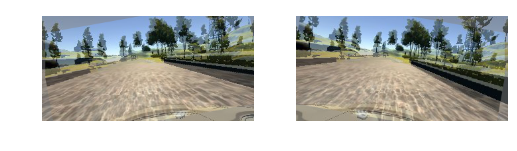

In [11]:
angle_rot = 10
trans_camera = 5


rows,cols,channels = image_c.shape

Mt = np.float32([[1,0,-trans_camera],[0,1,0]])
Mr = cv2.getRotationMatrix2D((cols/2,rows/2),-angle_rot,1)
rows,cols,channels = image_c.shape
image_c_mod = cv2.warpAffine(image_c,Mr,(cols,rows))
image_c_mod = cv2.warpAffine(image_c_mod,Mt,(cols,rows))
image_rc_mod = cv2.addWeighted(image_r,0.5,image_c_mod,0.5,0)

Mt = np.float32([[1,0,trans_camera],[0,1,0]])
Mr = cv2.getRotationMatrix2D((cols/2,rows/2),angle_rot,1)
rows,cols,channels = image_c.shape
image_c_mod = cv2.warpAffine(image_c,Mr,(cols,rows))
image_c_mod = cv2.warpAffine(image_c_mod,Mt,(cols,rows))
image_lc_mod = cv2.addWeighted(image_l,0.5,image_c_mod,0.5,0)

plt.subplot(1,2,1)
plt.imshow(image_lc_mod+.5)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image_rc_mod+.5)
plt.axis('off');

In [12]:
def plot_camera_images(data,steer_sm,ind_num,deg = 0):
    image_c = process_newimage_file(data['center'][ind_num].strip())
    image_r = process_newimage_file(data['right'][ind_num].strip())
    image_l = process_newimage_file(data['left'][ind_num].strip())
    plt.subplot(1,3,1)
    plt.imshow(image_l+.5);
    plt.axis('off')
    if deg==0:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num]+.25,2) ));
    else:
        plt.title('Steer:'+ str((np.round((steer_sm[ind_num]+.1)*180/np.pi,2) )))
    plt.subplot(1,3,2)
    plt.imshow(image_c+.5);
    plt.axis('off')
    if deg==0:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num],2) ));
    else:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num]*180/np.pi,2) ));
    plt.subplot(1,3,3)
    plt.imshow(image_r+.5);
    plt.axis('off');
    if deg==0:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num]-.25,2) ));
    else:
        plt.title('Steer:'+ str((np.round((steer_sm[ind_num]-.1)*180/np.pi,2) )))
    

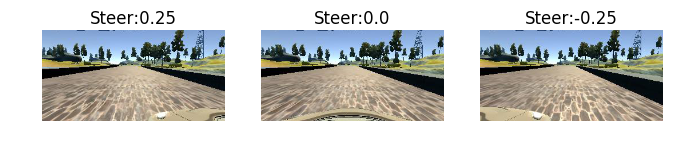

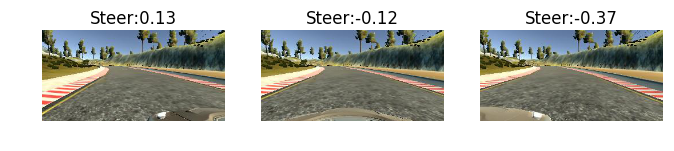

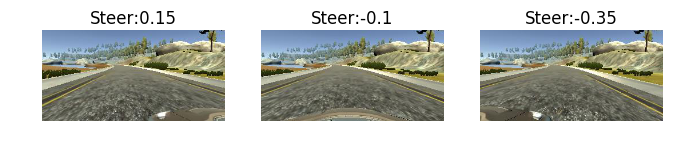

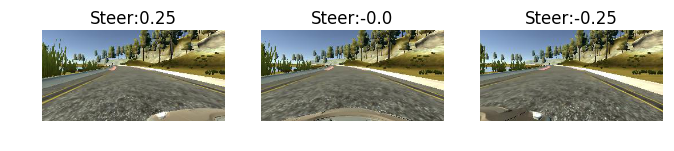

In [13]:
for i in range(4):
    i_random = np.random.randint(len(data_files_s)-1)
    plt.figure(figsize=(8,16))
    plot_camera_images(data_files_s,steer_sm_s,i_random,0)
    plt.show()


### Augmentation 2: Brightness augmentation

I next converted camera image's brightness so the car can learn to operate in both day and night conditions. To do brightness augmentation, I converted RGB image to HSV, scaled V (brightness) channel by a random number between .25 and 1.25, and converted the image back to RGB. 

In [14]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
        

In [15]:
image2 = cv2.imread(data_files_s['center'][1].strip())
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

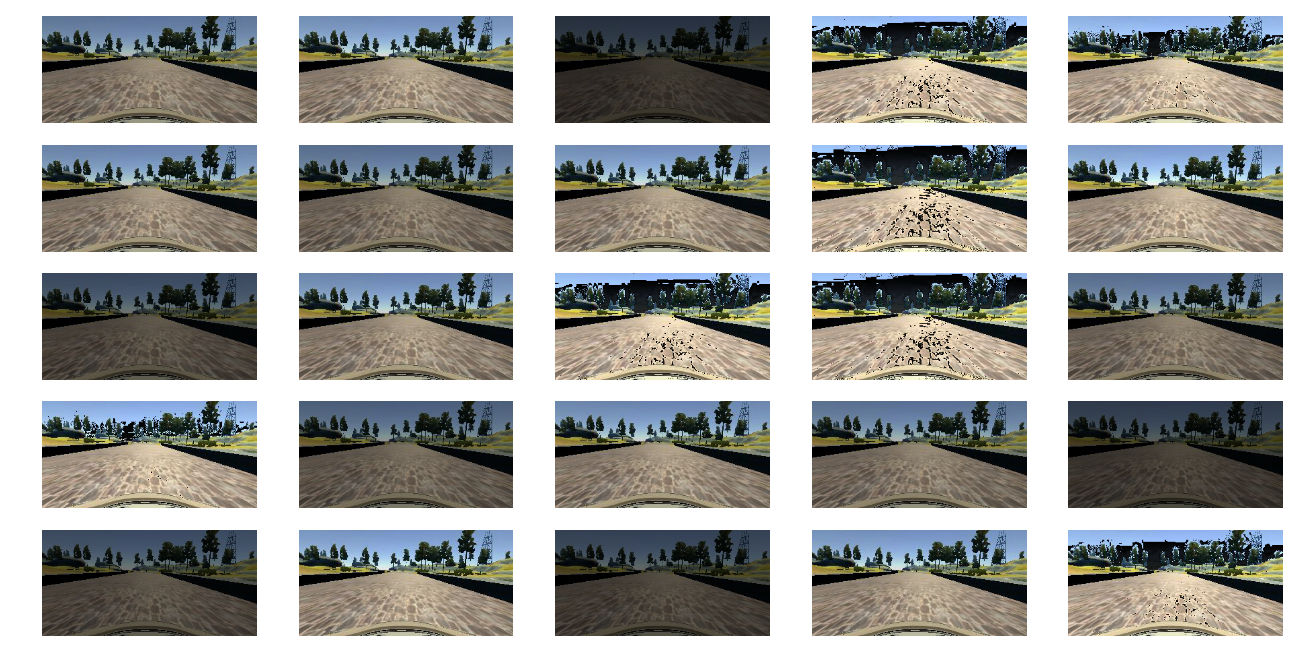

In [16]:
plt.figure(figsize=(16,8))
for i in range(25):
    image1 = augment_brightness_camera_images(image2)
    plt.subplot(5,5,i+1)
    plt.imshow(image1)
    plt.axis('off')


### Augmentation 3: Shifting left/right and up/down. 

I next shifted camera images to left and right to simulate the effect of the car at different positions in the lane. To simulate lane shifts, I applied random shifts in horizontal direction of upto 10 pixels, and applied angle change of .2 per pixel. 

In [17]:
image = cv2.imread(data_files_s['center'][85].strip())
steer = data_files_s['steer_sm'][1]
image_l = cv2.imread(data_files_s['left'][85].strip())
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_l = cv2.cvtColor(image_l,cv2.COLOR_BGR2RGB)

In [18]:
def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 10*np.random.uniform()-10/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang,tr_x

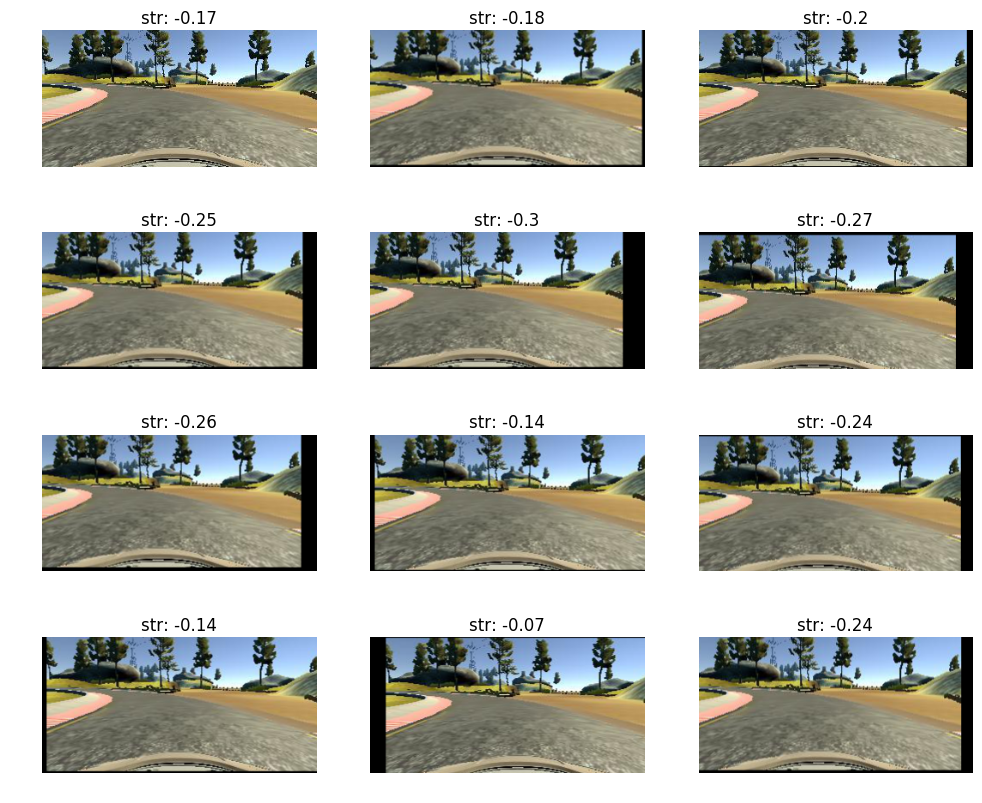

In [19]:
plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('str: ' + str(np.round(steer,2)))
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    image_tr,steer_ang,tr_x = trans_image(image,steer,80)
    plt.title('str: ' + str(np.round(steer_ang,2)) )
    plt.imshow(image_tr)
    plt.axis('off');

### Augmentation 4: Flipping images

I flipped images about the vertical midline to simulate driving in the opposite direction. The data collected had a lot of left turns, so to balance the left and right turns, images were flipped about the vertical axis at random. The anges corresponding to flipped images were multiplied by -1 to correct for steering in the opposite direction. 

### Augmentation: All together

Code below presents the final augmentation scheme all put together. 


### Preprocessing

I performed simple preprocessing where I cropped the top 1/4 of the image and bottom 25 pixels. I removed bottom pixels to remove the hood of the car. I also rescaled images to 64X64, After these, the final images inputs to network look as follows. 

In [20]:
new_size_col = 64
new_size_row = 64

def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
    #image = image/255.-.5
    return image 

def preprocess_image_file_train(line_data):
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = line_data['left'][0].strip()
        shift_ang = .25
    if (i_lrc == 1):
        path_file = line_data['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = line_data['right'][0].strip()
        shift_ang = -.25
    y_steer = line_data['steer_sm'][0] + shift_ang
    image = cv2.imread(path_file)
    #image = cv2.resize(image,(120,120))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image,y_steer,tr_x = trans_image(image,y_steer,150)
    image = augment_brightness_camera_images(image)
    image = preprocessImage(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image,y_steer

def preprocess_image_file_predict(line_data):
    path_file = line_data['center'][0].strip()
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #image = image/255.-.5
    image = preprocessImage(image)
    image = np.array(image)
    return image

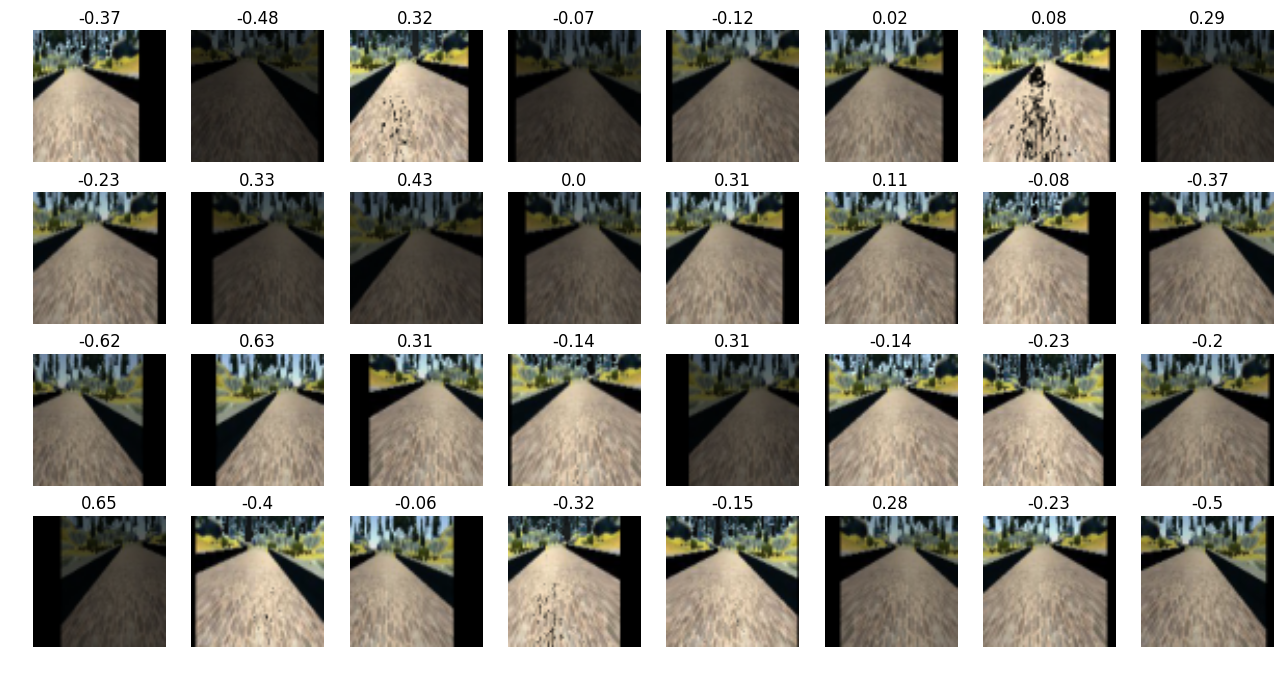

In [21]:
line_data = data_files_s.iloc[[2]].reset_index()
plt.figure(figsize=(16,8))
for i in range(32):
    image,steer = preprocess_image_file_train(line_data)

    plt.subplot(4,8,i+1)
    plt.imshow(image);
    plt.axis('off')
    plt.title(str(np.round(steer,2)))

### Keras generator and subsampling

As most of the car's driving was done along straight line, it is highly likely that the car is biased toward going straight. To remove this bias, I subsampled data to drop small angles with  probabilities. The drop probability was high in the initial part, and was reduced as training epochs progressed. 

In [22]:
pr_threshold = 1

def generate_train_from_PD_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                x,y = preprocess_image_file_train(line_data)
                pr_unif = np.random
                if abs(y)<.15:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

In [23]:
def generate_train_from_PD(data):
    while 1:
        i_line = np.random.randint(len(data))
        line_data = data.iloc[[i_line]].reset_index()
        x,y = preprocess_image_file_train(line_data)
        x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        y = np.array([[y]])
        yield x, y

def generate_valid_from_PD(data):
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index()
            #print(line_data)
            x = preprocess_image_file_predict(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steer_sm'][0]
            y = np.array([[y]])
            yield x, y

        
valid_s_generator = generate_valid_from_PD(data_files_s)

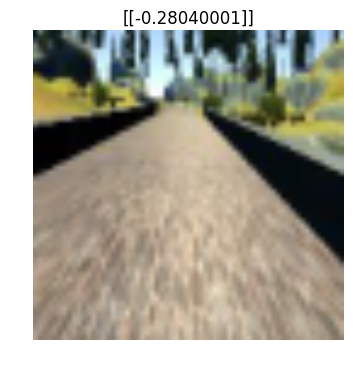

In [24]:
for i in range(100):
    next(valid_s_generator)
img,steer = next(valid_s_generator)
plt.imshow(img[0]);
plt.axis('off')
plt.title(str(np.round(steer,4)));

### Model architecture

<img src = small_model.png>

I implemented the model architecture above for training the data. The first layer is 3 1X1 filters, this has the effect of transforming the color space of the images. Research has shown that different color spaces are better suited for different applications. As we do not know the best color space apriori, using 3 1X1 filters allows the model to choose its best color space. This is followed by 3 convolutional blocks each comprised of 32, 64 and 128 filters of size 3X3. These convolution layers were followed by 3 fully connected layers. All the convolution blocks and the 2 following fully connected layers had leaky relu as activation function. I chose leaky relu to make transition between angles smoother.

In [25]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras import initializations

Using TensorFlow backend.


In [26]:
import tensorflow as tf
tf.python.control_flow_ops = tf
new_size_row = 64
new_size_col = 64

input_shape = (new_size_row, new_size_col, 3)


filter_size = 3

pool_size = (2,2)
model = Sequential()
#model.add(MaxPooling2D(pool_size=pool_size,input_shape=input_shape))
model.add(Lambda(lambda x: x/255.-0.5,input_shape=input_shape))

model.add(Convolution2D(3,1,1,
                        border_mode='valid',
                        name='conv0', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv1', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv2', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv3', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv4', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Dropout(0.5))


model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv5', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv6', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(512,name='hidden1', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(64,name='hidden2', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(16,name='hidden3',init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(1, name='output', init='he_normal'))

In [27]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam,
          loss='mse')


### Training


I trained the model using the keras generator with batch size of 256 for 8 epochs. In each epoch, I generated 20000 images. I started with pr_threshold, the chance of dropping data with small angles as 1, and reduced the probability by dividing it by the iteration number after each epoch. The entire training took about 5 minutes. However, it too more than 20 hours to arrive at the right architecture and training parameters.

In [28]:
from pathlib import Path
import json

def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)

In [29]:
val_size = len(data_files_s)
pr_threshold = 1

batch_size = 256

i_best = 0
val_best = 1000

for i_pr in range(10):

    train_r_generator = generate_train_from_PD_batch(data_files_s,batch_size)

    nb_vals = np.round(len(data_files_s)/val_size)-1
    history = model.fit_generator(train_r_generator,
            samples_per_epoch=20224, nb_epoch=1,validation_data=valid_s_generator,
                        nb_val_samples=val_size)
    
    fileModelJSON = 'model_' + str(i_pr) + '.json'
    fileWeights = 'model_' + str(i_pr) + '.h5'
    
    save_model(fileModelJSON,fileWeights)
    
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i_pr 
        val_best = val_loss
        fileModelJSON = 'model_best.json'
        fileWeights = 'model_best.h5'
        save_model(fileModelJSON,fileWeights)
    
    
    pr_threshold = 1/(i_pr+1)
print('Best model found at iteration # ' + str(i_best))
print('Best Validation score : ' + str(np.round(val_best,4)))

Epoch 1/1
20224/20224 [==============================] - 88s - loss: 0.1073 - val_loss: 0.0147
Epoch 1/1
20224/20224 [==============================] - 87s - loss: 0.0880 - val_loss: 0.0153
Epoch 1/1
20224/20224 [==============================] - 75s - loss: 0.0751 - val_loss: 0.0104
Epoch 1/1
20224/20224 [==============================] - 72s - loss: 0.0682 - val_loss: 0.0084
Epoch 1/1
20224/20224 [==============================] - 71s - loss: 0.0636 - val_loss: 0.0135
Epoch 1/1
20224/20224 [==============================] - 73s - loss: 0.0611 - val_loss: 0.0158
Epoch 1/1
20224/20224 [==============================] - 69s - loss: 0.0587 - val_loss: 0.0133
Epoch 1/1
20224/20224 [==============================] - 69s - loss: 0.0580 - val_loss: 0.0129
Epoch 1/1
20224/20224 [==============================] - 69s - loss: 0.0574 - val_loss: 0.0100
Epoch 1/1
20224/20224 [==============================] - 69s - loss: 0.0560 - val_loss: 0.0115
Best model found at iteration # 3
Best Validation 

Once I got the model and weights from above, I went through each model and chose the model that performed the best on the track. The model that performed the best on the track. Surprising, the model that performed best was obtained at iteration 8, which had higher loss.



### Reflection

This was perhaps the weirdest project I did. This project challenged all the previous knowledge I had about deep learning. In general large epoch size and training with more data results in better performance, but in this case any time I got beyond 10 epochs, the car simply drove off the track. Although all the image augmentation and tweaks seem reasonable now, I did not think of them apriori. 